Task 1

In [91]:
import numpy as np

def generate_inter_arrivals(lam):
    return np.random.exponential(scale = 1/lam)

def generate_length_of_stay(mean_length):
    return np.random.exponential(scale = mean_length)


def simulate_arrival_time(lam, n_days):
    arrival_sum = 0
    times = []
    while arrival_sum < n_days:
        new_time = generate_inter_arrivals(lam)
        new_sum = arrival_sum + new_time
        if compute_day(new_sum) >= n_days:
            break
        arrival_sum += new_time
        times.append(new_time)
    
    times = np.array(times)
    arrival_times = np.cumsum(times)
    return arrival_times

def choose_new_ward(i, P):
    prob = P[i,:]
    choices = P.shape[0]
    new_ward = np.random.choice(np.arange(0,choices), p= prob)
    return new_ward

def generate_list_of_arrivals(arrival_times, keys):
    arrival_tuples = []
    for i, key in enumerate(keys):
        for t in arrival_times[i]:  
            arrival_tuples.append((t, key)) 

    arrival_tuples.sort(key=lambda x: x[0])
    return arrival_tuples 

def add_leaving_time(leaving_times, leaving_time_and_ward):
    leaving_times.append(leaving_time_and_ward)
    leaving_times.sort(key=lambda x: x[0])

def remove_free_beds(leaving_times, arr_time, available_beds):
    to_remove = [lt for lt in leaving_times if arr_time >= lt[0]]
    for lt in to_remove:
            leaving_times.remove(lt)
            available_beds[lt[1]] += 1

def handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length):
    available_beds[next_ward] -= 1
    degency_time = generate_length_of_stay(mean_length[next_ward])
    leaving_time = arr_time + degency_time
    add_leaving_time(leaving_times, (leaving_time, next_ward))

def compute_day(arr_time):
    day = int(np.floor(arr_time))
    return day


In [92]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80],
    [0.20, 0.00, 0.50, 0.15, 0.15],
    [0.30, 0.20, 0.00, 0.20, 0.30],
    [0.35, 0.30, 0.05, 0.00, 0.30],
    [0.20, 0.10, 0.60, 0.10, 0.00],
    ])


In [93]:
# Simulate
def simulate(lams, mean_length, n_days, available_beds, penalty):


    arrival_times = [simulate_arrival_time(lam, n_days) for lam in lams]
    wards = np.arange(0, P.shape[1])
    event_list = generate_list_of_arrivals(arrival_times, wards)
    leaving_times = []
    rejected_patients = np.zeros(n_days)
    total_rejected = [0]
    available_beds_matrix = available_beds.reshape(1, -1)  # Shape: (1, n_wards)
    days = []
    relocation_matrix = np.zeros(P.shape)
    computed_penalty = np.zeros(penalty.shape)

    for j in range(len(event_list)):
        arr_time, next_ward = event_list[j]
        day = compute_day(arr_time)
        days.append(day)
        
        if j >= 1:
            previous_day = compute_day(event_list[j-1][0])
        else: previous_day = 0

        # Remove patients who have already left before the current arrival time
        remove_free_beds(leaving_times, arr_time, available_beds)
            

        # Check if there are avaiable beds
        if available_beds[next_ward] > 0:
            handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
        # If there are no beds available, send the patient to another ward with probability p_ij
        else:
            computed_penalty[next_ward] += penalty[next_ward]
            old_ward = next_ward
            next_ward =  choose_new_ward(next_ward, P)
            relocation_matrix[old_ward, next_ward] += 1
            if available_beds[next_ward] > 0:
                handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
                #print('patient handled by another ward')
            else: 
                rejected_patients[day] += 1
                total_rejected.append(total_rejected[-1]+1)
                #print('patient rejected')
                continue
       
        available_beds_matrix = np.vstack([available_beds_matrix, available_beds.reshape(1, -1)])

    return available_beds_matrix, rejected_patients, relocation_matrix, computed_penalty

In [94]:
lams = [14.5, 11.0, 8.0, 6.5, 5.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9]

n_days = 100

available_beds = np.array([55, 40, 30, 20, 20])

penalty = np.array([7, 5, 2, 10, 5])

available_beds_matrix, rejected_patients, relocation_matrix, penaltys = simulate(lams, mean_length, n_days, available_beds, penalty)

In [97]:
#print(available_beds_matrix)
#print(rejected_patients)
print(relocation_matrix)
#print(penaltys)
print(P)
print("Sum by rows of relocation matrix:", np.sum(relocation_matrix, axis=1))


[[  0.   2.   8.   4.  37.]
 [ 54.   0. 113.  40.  30.]
 [ 84.  51.   0.  54.  93.]
 [  4.   2.   1.   0.   3.]
 [ 28.  19. 105.  14.   0.]]
[[0.   0.05 0.1  0.05 0.8 ]
 [0.2  0.   0.5  0.15 0.15]
 [0.3  0.2  0.   0.2  0.3 ]
 [0.35 0.3  0.05 0.   0.3 ]
 [0.2  0.1  0.6  0.1  0.  ]]
Sum by rows of relocation matrix: [ 51. 237. 282.  10. 166.]


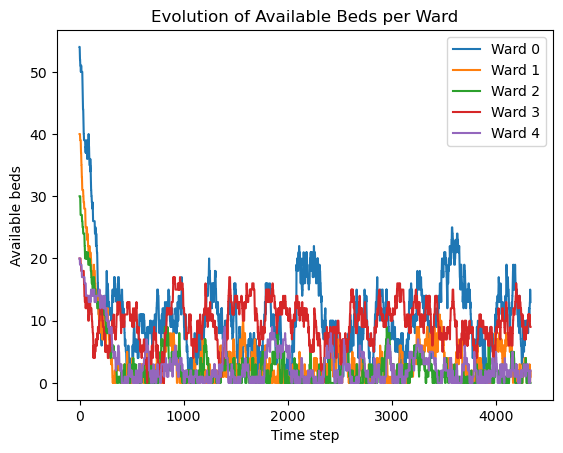

In [73]:
import matplotlib.pyplot as plt

for ward_idx in range(available_beds_matrix.shape[1]):
    plt.plot(available_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Available beds')
plt.title('Evolution of Available Beds per Ward')
plt.legend()
plt.show()


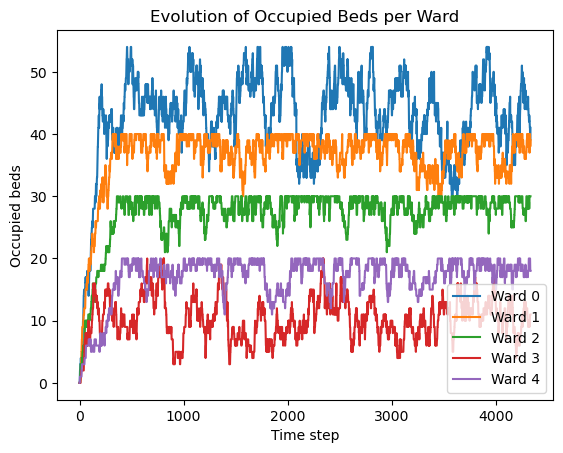

In [74]:
initial_beds = available_beds_matrix[0]
occupied_beds_matrix = initial_beds - available_beds_matrix

for ward_idx in range(occupied_beds_matrix.shape[1]):
    plt.plot(occupied_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Occupied beds')
plt.title('Evolution of Occupied Beds per Ward')
plt.legend()
plt.show()

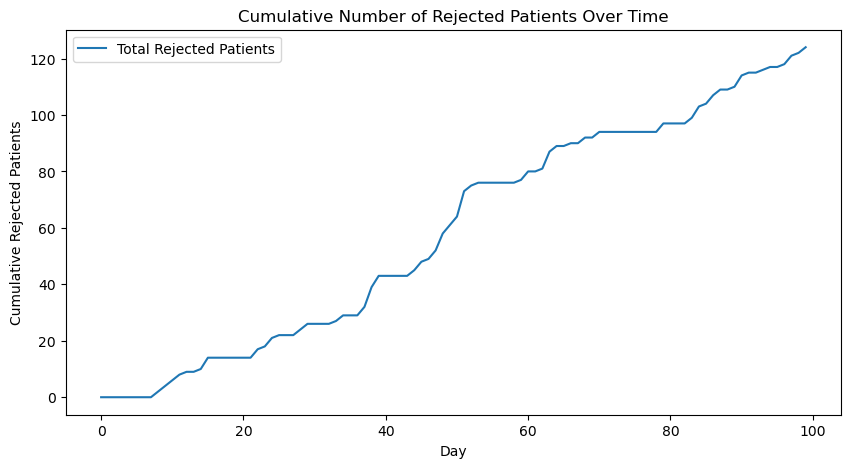

In [75]:
total_rejected = np.cumsum(rejected_patients)
plt.figure(figsize=(10, 5))
plt.plot(total_rejected, label='Total Rejected Patients')
plt.xlabel('Day')
plt.ylabel('Cumulative Rejected Patients')
plt.title('Cumulative Number of Rejected Patients Over Time')
plt.legend()
plt.show()

Task 2

We need to find the minimum number of beds to give to ward F in order to have an acceptance rate of 95%

To do so, we use Erlang's-B formula 
A = lams * mean service time = 13.0 * 2.2
To use the formula to compute the probability of blocking, and we should make sure that the the probabily of blocking is less the 5%


In [76]:
from scipy.special import factorial

lam = 13.0
mean_length = 2.2
A = lam * mean_length
m_vector = np.arange(10,50)

def block_prob(A, m):
    nominator = A ** m / (factorial(m))
    denominator =  sum(A**i/factorial(i) for i in range(0,m+1))
    return nominator / denominator

for m in m_vector:
    p = block_prob(A,m)
    print(f'Probability of blocking with {m} beds is: {p}')
    if p <= 0.05:
        print(f'found p = {p} => number of beds = {m}')
        break


Probability of blocking with 10 beds is: 0.6667154065199613
Probability of blocking with 11 beds is: 0.6341633024939435
Probability of blocking with 12 beds is: 0.60181929363769
Probability of blocking with 13 beds is: 0.5697078539138748
Probability of blocking with 14 beds is: 0.5378568615721447
Probability of blocking with 15 beds is: 0.5062980933615348
Probability of blocking with 16 beds is: 0.4750677776679584
Probability of blocking with 17 beds is: 0.4442072052218292
Probability of blocking with 18 beds is: 0.41376339088674924
Probability of blocking with 19 beds is: 0.3837897722685502
Probability of blocking with 20 beds is: 0.3543469196183506
Probability of blocking with 21 beds is: 0.325503215817002
Probability of blocking with 22 beds is: 0.2973354442840266
Probability of blocking with 23 beds is: 0.2699291960117923
Probability of blocking with 24 beds is: 0.24337897506199982
Probability of blocking with 25 beds is: 0.21778784695106335
Probability of blocking with 26 beds is:

In [77]:
def simulate_t2(lams, mean_length, n_days, available_beds, penalty):

    rejected_F = 0
    total_patients_F = 0
    arrival_times = [simulate_arrival_time(lam, n_days) for lam in lams]
    wards = np.arange(0, P.shape[1])
    event_list = generate_list_of_arrivals(arrival_times, wards)
    leaving_times = []
    rejected_patients = np.zeros(n_days)
    total_rejected = [0]
    available_beds_matrix = available_beds.reshape(1, -1)  # Shape: (1, n_wards)
    days = []
    relocation_matrix = np.zeros(P.shape)
    computed_penalty = np.zeros(penalty.shape, dtype = int)

    for j in range(len(event_list)):
        arr_time, next_ward = event_list[j]
        day = compute_day(arr_time)
        days.append(day)
        if next_ward == 5: total_patients_F += 1
        
        if j >= 1:
            previous_day = compute_day(event_list[j-1][0])
        else: previous_day = 0

        # Remove patients who have already left before the current arrival time
        remove_free_beds(leaving_times, arr_time, available_beds)
            

        # Check if there are avaiable beds
        if available_beds[next_ward] > 0:
            handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
        # If there are no beds available, send the patient to another ward with probability p_ij
        else:
            computed_penalty[next_ward] += penalty[next_ward]
            old_ward = next_ward
            next_ward =  choose_new_ward(next_ward, P)
            relocation_matrix[old_ward, next_ward] += 1

            if old_ward == 5: rejected_F += 1

            if available_beds[next_ward] > 0:
                handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
                #print('patient handled by another ward')
            else: 
                rejected_patients[day] += 1
                total_rejected.append(total_rejected[-1]+1)
                #print('patient rejected')
                continue
       
        available_beds_matrix = np.vstack([available_beds_matrix, available_beds.reshape(1, -1)])
    acceptance_rate_F =1 -(rejected_F / total_patients_F)
    total_penalty = np.sum(computed_penalty)

    return available_beds_matrix, rejected_patients, relocation_matrix, computed_penalty, total_penalty, acceptance_rate_F

In [78]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
    ])

lams = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

n_days = 100

available_beds = np.array([55, 40, 30, 20, 20, 34])

penalty = np.array([7, 5, 2, 10, 5, 0])

In [79]:
available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty, acceptance_rate_F = simulate_t2(lams, mean_length, n_days, available_beds, penalty)

In [80]:
print(acceptance_rate_F)

0.9331329827197596


In [81]:
# Use simulated annealing to find the distribution of beds, i.e. where shuld we take the beds away from to give them to ward F
# Idea: Start from a configuration of beds, then compute the penalty, and use it in the Simulated Annealing to
# evaluate the solution. Accept only simulations where 95% of patients are accepted in F

def cooling_scheme(k):
    return 1 / np.sqrt(1 + k)



In [82]:
# Implementation of SA

P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
    ])

lams = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

n_days = 100

initial_beds = np.array([55, 40, 30, 20, 20])
total_beds = np.sum(initial_beds)
beds_ward6 = 34
parts = 5
min_beds = 1

remaining = beds_ward6- parts * min_beds
cuts = np.sort(np.random.choice(range(1, remaining + parts), parts - 1, replace=False))
split = np.diff([0] + cuts.tolist() + [remaining])
split = split + min_beds

bed_alloc_guess = initial_beds - split
bed_alloc_guess = np.append(bed_alloc_guess, beds_ward6)
print(bed_alloc_guess)
print(np.sum(bed_alloc_guess))



[47 33 28  2 21 34]
165


In [83]:
# Run the simulated annealing to find the optimal distrbibution

N_iter = 100

costs = np.empty(N_iter)

penalty = np.array([7, 5, 2, 10, 5, 0])

available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty_guess, acceptance_rate_F = simulate_t2(lams, mean_length, n_days, np.copy(bed_alloc_guess), penalty)
print(f'Starting distribution: {bed_alloc_guess}, with penalty: {total_penalty_guess}')

for n in range(N_iter):
    T = cooling_scheme(n)

    remaining = beds_ward6- parts * min_beds
    cuts = np.sort(np.random.choice(range(1, remaining + parts), parts - 1, replace=False))
    split = np.diff([0] + cuts.tolist() + [remaining])
    split = split + min_beds

    new_proposal = initial_beds - split
    new_proposal = np.append(new_proposal, beds_ward6)


    available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty_new, acceptance_rate_F = simulate_t2(lams, mean_length, n_days, np.copy(new_proposal), penalty)

    diff_energy = total_penalty_new - total_penalty_guess

    u = np.random.uniform(0, 1)
    if diff_energy <= 0:
        bed_alloc_guess = new_proposal
        total_penalty_guess = total_penalty_new
    elif u < np.exp( - diff_energy / T):
        bed_alloc_guess = new_proposal
        total_penalty_guess = total_penalty_new

    print(bed_alloc_guess)
    print(np.sum(bed_alloc_guess))
    costs[n] = total_penalty_guess


Starting distribution: [47 33 28  2 21 34], with penalty: 11739
[40 35 26  8 22 34]
165
[40 35 26  8 22 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[52 36  6 18 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165
[48 31 17 16 19 34]
165



Best configuration found:
Beds: [48 31 17 16 19 34]
Acceptance rate F*: 0.9425801640566741
Total penalty: 5009


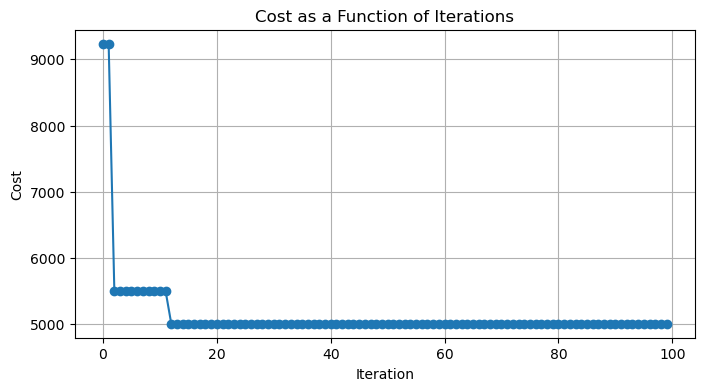

In [84]:
print("\nBest configuration found:")
print("Beds:", bed_alloc_guess)
print("Acceptance rate F*:", acceptance_rate_F)
print("Total penalty:", total_penalty_guess)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(N_iter), costs, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost as a Function of Iterations')
plt.grid(True)
plt.show()

In [85]:
print(costs)

[9236. 9236. 5502. 5502. 5502. 5502. 5502. 5502. 5502. 5502. 5502. 5502.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009. 5009.
 5009. 5009. 5009. 5009.]


In [86]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
    ])

lams = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

n_days = 100

available_beds = bed_alloc_guess

penalty = np.array([7, 5, 2, 10, 5, 0])

Task 3

In [87]:
available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty, acceptance_rate_F = simulate_t2(lams, mean_length, n_days, np.copy(available_beds), penalty)

In [88]:
#print(available_beds_matrix)
#print(rejected_patients)
print(relocation_matrix)
#print(penaltys)
print(P)
print(bed_alloc_guess)
print("Sum by rows of relocation matrix:", np.sum(relocation_matrix, axis=1))
print(acceptance_rate_F)

[[  0.   9.  18.  14. 186.   0.]
 [ 78.   0. 211.  76.  68.   0.]
 [171. 112.   0. 102. 157.   0.]
 [ 24.  14.   2.   0.  18.   0.]
 [ 43.  30. 151.  33.   0.   0.]
 [ 15.  21.  15.  16.   8.   0.]]
[[0.   0.05 0.1  0.05 0.8  0.  ]
 [0.2  0.   0.5  0.15 0.15 0.  ]
 [0.3  0.2  0.   0.2  0.3  0.  ]
 [0.35 0.3  0.05 0.   0.3  0.  ]
 [0.2  0.1  0.6  0.1  0.   0.  ]
 [0.2  0.2  0.2  0.2  0.2  0.  ]]
[48 31 17 16 19 34]
Sum by rows of relocation matrix: [227. 433. 542.  58. 257.  75.]
0.9424405218726017


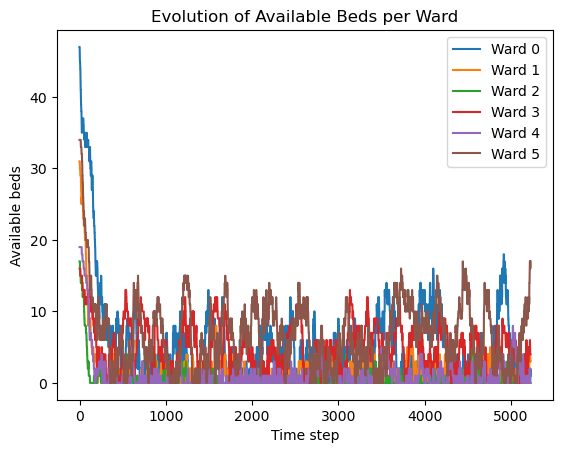

In [89]:
import matplotlib.pyplot as plt

for ward_idx in range(available_beds_matrix.shape[1]):
    plt.plot(available_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Available beds')
plt.title('Evolution of Available Beds per Ward')
plt.legend()
plt.show()

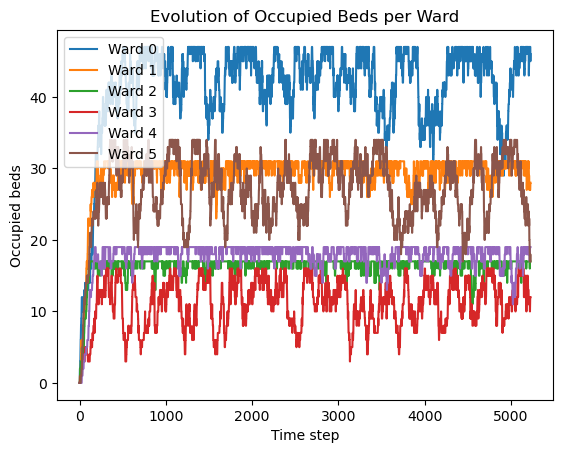

In [90]:
initial_beds = available_beds_matrix[0]
occupied_beds_matrix = initial_beds - available_beds_matrix

for ward_idx in range(occupied_beds_matrix.shape[1]):
    plt.plot(occupied_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Occupied beds')
plt.title('Evolution of Occupied Beds per Ward')
plt.legend()
plt.show()

Implications of adding a new ward F:

Looking at the relocation matrix, we see that, since we chose F s.t. we have an acceptance rate around 95%, there are not many patients
who are sent to other wards, when they should go to F.
As a matter of fact, ward F is the one with the lowest rejections, together with ward D which has the lowest mean time stay.

Furthermore, the patients are sent evenly to other wards, when the come from ward F, as represented by the probabilties in the P matrix.

Most importantly, adding ward F with these conditions: high acceptance rate, and no patients can be sent to it, implies that in the other
wards the rejections are way higher, as well as the relocations between these wards.
